# CIFAR-10 
- 10 class
- 32*32 color image
- 5M: train
- 1M: test

In [0]:
import torch 
import torchvision
import torchvision.transforms as transforms

In [31]:
torch.__version__

'1.5.0+cu101'

In [0]:
# transformを定義する
# データを変換する RGB平均，　標準偏差
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [33]:
# train_test_split
# --train data-- num_workersはコアの数
train_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='~/data', train=True, download=True, transform=transform)

Extracting /root/data/cifar-10-python.tar.gz to /root/data


In [0]:
# ミニバッチを扱うためのデータローダー（loader）を作成
train_data_loader = torch.utils.data.DataLoader(train_data_with_teacher_labels, batch_size=4, shuffle=True)

In [35]:
# --test data--
test_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='~/data', train=False, download=True, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data_with_teacher_labels, batch_size=4, shuffle=False)

Files already downloaded and verified


In [0]:
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [0]:
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# 画像を表示する関数
def show_image(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

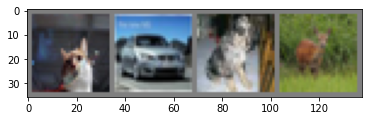

cat
car
dog
deer


In [41]:
data_iterator = iter(train_data_loader)
images, labels = data_iterator.next()

show_image(torchvision.utils.make_grid(images))
for i in labels:
  print(class_names[i])

In [42]:
class_names

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [43]:
labels

tensor([3, 1, 5, 4])

In [0]:
# ニューラルネットワークの定義
import torch.nn as nn
import torch.nn.functional as F

# class継承
class CNN(nn.Module):
  # 初期化
  def __init__(self):
    # -- super class --  親クラスのメソッドを子クラスでも使いつつ、新たにパラメーターやメソッドを追加する場合は、スーパークラス super() が便利
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.layer1 = nn.Linear(16*5*5, 120)
    self.layer2 = nn.Linear(120, 84)
    self.layer3 = nn.Linear(84, 10)

  def forward(self, input_data):
    input_data = self.pool(F.relu(self.conv1(input_data)))
    input_data = self.pool(F.relu(self.conv2(input_data)))
    input_data = input_data.view(-1, 16*5*5)
    input_data = F.relu(self.layer1(input_data))
    input_data = F.relu(self.layer2(input_data))
    input_data = self.layer3(input_data)
    return input_data
  

model = CNN()



In [0]:
# optimozerの設定
import torch.optim as optimizer
# cross entropy
criterion = nn.CrossEntropyLoss()
optimizer = optimizer.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [77]:
# --学習--

# 最大学習回数
from tqdm import tqdm 
MAX_EPOCH = 3

for epoch in tqdm(range(MAX_EPOCH)):
  total_loss = 0.0
  for i, data in enumerate(train_data_loader, 0):
    # dataから学習データと教師ラベルデータを取り出す
    train_data, teacher_labels = data

    # 計算された勾配情報を削除
    optimizer.zero_grad

    # モデルでの予測を計算
    outputs = model(train_data)

    # lossとwによる微分計算
    loss = criterion(outputs, teacher_labels)
    loss.backward()

    # 勾配を更新
    optimizer.step()

    # 誤差を累計
    total_loss += loss.item()

    # 2000ミニバッチずつ，進捗を表示する
    if i % 2000 == 1999:
      print('学習進捗: [%d, %5d] loss: %.3f' % (epoch + 1, i+1, total_loss/2000))
      total_loss = 0.0


print('学習完了')







  0%|          | 0/3 [00:00<?, ?it/s]

学習進捗: [1,  2000] loss: 2.328
学習進捗: [1,  4000] loss: 2.336
学習進捗: [1,  6000] loss: 227.158
学習進捗: [1,  8000] loss: 2.406
学習進捗: [1, 10000] loss: 2.492
学習進捗: [1, 12000] loss: 2.409







 33%|███▎      | 1/3 [00:45<01:31, 45.51s/it]

学習進捗: [2,  2000] loss: 2.398
学習進捗: [2,  4000] loss: 2.400
学習進捗: [2,  6000] loss: 2.383
学習進捗: [2,  8000] loss: 2.378
学習進捗: [2, 10000] loss: 2.384
学習進捗: [2, 12000] loss: 2.372







 67%|██████▋   | 2/3 [01:32<00:45, 45.85s/it]

学習進捗: [3,  2000] loss: 2.369
学習進捗: [3,  4000] loss: 2.361
学習進捗: [3,  6000] loss: 2.362
学習進捗: [3,  8000] loss: 2.365
学習進捗: [3, 10000] loss: 2.352
学習進捗: [3, 12000] loss: 2.357







100%|██████████| 3/3 [02:17<00:00, 46.00s/it]

学習完了


In [78]:
total_loss

1166.8987786769867

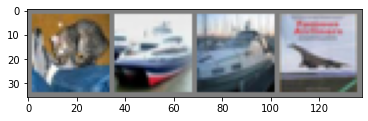

正解ラベル：
cat
ship
ship
plane


In [79]:
# 検証
data_iterator = iter(test_data_loader)
images, labels = data_iterator.next()


show_image(torchvision.utils.make_grid(images))
print('正解ラベル：')
for i in labels:
  print(class_names[i])

In [82]:
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('予測ラベル：')
for j in range(4):
  print(class_names[predicted[j]])

予測ラベル：
car
car
car
car


In [83]:
count_when_correct = 0
total = 0
with torch.no_grad():
  for data in test_data_loader:
    test_data, teacher_labels = data
    results = model(test_data)
    _, predicted = torch.max(results.data, 1)
    total += teacher_labels.size(0)
    count_when_correct += (predicted == teacher_labels).sum().item()
  
print('精度：')
print(100*count_when_correct / total)

精度：
10.0


# ネットで見つけたいいサイト
URL: https://rightcode.co.jp/blog/information-technology/pytorch-cifar-10-cnn-learning  <br>
【前編】PyTorchでCIFAR-10をCNNに学習させる【PyTorch基礎】

In [0]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
def load_cifar10(batch=128):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    return {'train': train_loader, 'test': test_loader}



Files already downloaded and verified
Files already downloaded and verified
torch.Size([128, 3, 32, 32])


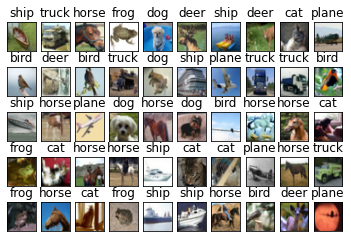

In [86]:
if __name__ == '__main__':
    loader = load_cifar10()
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')  # CIFAR10のクラス

    for images, labels in loader['train']:
        print(images.shape)  # torch.Size([128, 3, 32, 32])

        # 試しに50枚を 5x10 で見てみる
        for i in range(5):
            for j in range(10):
                image = images[i*10+j] / 2 + 0.5
                image = image.numpy()
                plt.subplot(5, 10, i*10+j + 1)
                plt.imshow(np.transpose(image, (1, 2, 0)))  # matplotlibではチャネルは第3次元
                
                # 対応するラベル
                plt.title(classes[int(labels[i*10+j])])
                
                # 軸目盛や値はいらないので消す
                plt.tick_params(labelbottom=False,
                                labelleft=False,
                                labelright=False,
                                labeltop=False,
                                bottom=False,
                                left=False,
                                right=False,
                                top=False)

        plt.show()
        break

In [0]:
# LeNetをベースにネットワーク作成
class MyCNN(torch.nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,  # チャネル入力
                                     6,  # チャンネル出力
                                     5,  # カーネルサイズ
                                     1,  # ストライド (デフォルトは1)
                                     0,  # パディング (デフォルトは0)
                                     )
        self.conv2 = torch.nn.Conv2d(6, 16, 5)

        self.pool = torch.nn.MaxPool2d(2, 2)  # カーネルサイズ, ストライド

        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)  # 入力サイズ, 出力サイズ
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = self.pool(x)
        x = f.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)  # 1次元データに変えて全結合層へ
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [0]:
   # 畳み込むフィルタを可視化
    def plot_conv1(self, prefix_num=0):
        weights1 = self.conv1.weight
        weights1 = weights1.reshape(3*6, 5, 5)

        for i, weight in enumerate(weights1):
            plt.subplot(3, 6, i + 1)
            plt.imshow(weight.data.numpy(), cmap='winter')
            plt.tick_params(labelbottom=False,
                            labelleft=False,
                            labelright=False,
                            labeltop=False,
                            bottom=False,
                            left=False,
                            right=False,
                            top=False)

        plt.savefig('img/{}_conv1.png'.format(prefix_num))
        plt.close()

    def plot_conv2(self, prefix_num=0):
        weights2 = self.conv2.weight
        weights2 = weights2.reshape(6*16, 5, 5)

        for i, weight in enumerate(weights2):
            plt.subplot(6, 16, i + 1)
            plt.imshow(weight.data.numpy(), cmap='winter')
            plt.tick_params(labelbottom=False,
                            labelleft=False,
                            labelright=False,
                            labeltop=False,
                            bottom=False,
                            left=False,
                            right=False,
                            top=False)

        plt.savefig('img/{}_conv2.png'.format(prefix_num))
        plt.close()

In [92]:
# 学習
if __name__ == '__main__':
    epoch = 50

    loader = load_cifar10()
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    net: MyCNN = MyCNN()
    criterion = torch.nn.CrossEntropyLoss()  # ロスの計算
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.001, momentum=0.9)

   

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    for e in range(epoch):
        net.train()
        loss = None
        for i, (images, labels) in enumerate(loader['train']):
            optimizer.zero_grad()
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                print('Training log: {} epoch ({} / 50000 train. data). Loss: {}'.format(e + 1,
                                                                                         (i + 1) * 128,
                                                                                         loss.item())
                      )

        

Files already downloaded and verified
Files already downloaded and verified
Training log: 1 epoch (128 / 50000 train. data). Loss: 2.3131730556488037
Training log: 1 epoch (1408 / 50000 train. data). Loss: 2.314359664916992
Training log: 1 epoch (2688 / 50000 train. data). Loss: 2.307372570037842
Training log: 1 epoch (3968 / 50000 train. data). Loss: 2.3017075061798096
Training log: 1 epoch (5248 / 50000 train. data). Loss: 2.310061454772949
Training log: 1 epoch (6528 / 50000 train. data). Loss: 2.308582305908203
Training log: 1 epoch (7808 / 50000 train. data). Loss: 2.29620361328125
Training log: 1 epoch (9088 / 50000 train. data). Loss: 2.3061866760253906
Training log: 1 epoch (10368 / 50000 train. data). Loss: 2.2991480827331543
Training log: 1 epoch (11648 / 50000 train. data). Loss: 2.3090200424194336
Training log: 1 epoch (12928 / 50000 train. data). Loss: 2.306140184402466
Training log: 1 epoch (14208 / 50000 train. data). Loss: 2.312626600265503
Training log: 1 epoch (15488 

In [94]:
        net.eval()
        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(loader['train'])):
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / 50000)
        history['train_acc'].append(acc)

        correct = 0
        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(loader['test'])):
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        acc = float(correct / 10000)
        history['test_acc'].append(acc)







  0%|          | 0/391 [00:00<?, ?it/s]




  1%|          | 3/391 [00:00<00:14, 26.27it/s]




  2%|▏         | 6/391 [00:00<00:14, 26.81it/s]




  2%|▏         | 9/391 [00:00<00:14, 27.20it/s]




  3%|▎         | 12/391 [00:00<00:13, 27.83it/s]




  4%|▍         | 15/391 [00:00<00:13, 28.06it/s]




  5%|▍         | 18/391 [00:00<00:13, 27.41it/s]




  5%|▌         | 21/391 [00:00<00:13, 27.76it/s]




  6%|▌         | 24/391 [00:00<00:13, 27.32it/s]




  7%|▋         | 27/391 [00:00<00:13, 27.27it/s]




  8%|▊         | 30/391 [00:01<00:13, 27.20it/s]




  8%|▊         | 33/391 [00:01<00:13, 27.03it/s]




  9%|▉         | 36/391 [00:01<00:12, 27.41it/s]




 10%|▉         | 39/391 [00:01<00:12, 27.58it/s]




 11%|█         | 42/391 [00:01<00:12, 27.86it/s]




 12%|█▏        | 45/391 [00:01<00:12, 27.53it/s]




 12%|█▏        | 48/391 [00:01<00:12, 27.58it/s]




 13%|█▎        | 51/391 [00:01<00:12, 26.66it/s]




 14%|█▍        | 54/391 [00:01<00:12, 26.76it/s]






In [0]:
# 結果をプロット
# plt.plot(range(1, epoch+1), history['train_loss'])
# plt.title('Training Loss [CIFAR10]')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.savefig('img/cifar10_loss.png')
# plt.close()

# plt.plot(range(1, epoch + 1), history['train_acc'], label='train_acc')
# plt.plot(range(1, epoch + 1), history['test_acc'], label='test_acc')
# plt.title('Accuracies [CIFAR10]')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend()
# plt.savefig('img/cifar10_acc.png')
# plt.close()

In [99]:
history['train_acc']

[0.66518]

In [102]:
history['test_acc']

[0.6138]